# Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing

In [2]:
# make df with column names year, month, decimal date, SSN, M1, M2, M3, M4, M5 from file 5c_obs_sim_v1.dat
df = pd.read_csv('../5c_obs_sim_v1.dat', sep='\s+', header=None, names=['year', 'month', 'decimal_date', 'SSN', 'M1', 'M2', 'M3', 'M4', 'M5'])

# normalize data to be between 0 and 1 using max value from SSN
M = df['SSN'].max()
df['SSN'] = df['SSN'] / M
for i in range(1, 6):
    df[f'M{i}'] = df[f'M{i}'] / M


In [3]:
MODEL_SERIES_INPUT_SIZE = 4
OBSERVED_SERIES_INPUT_SIZE = 4

class MixedDataGenerator:
    def __init__(self,
                 model_series,
                 observed_series,
                 model_series_input_size=MODEL_SERIES_INPUT_SIZE,
                 observed_series_input_size=OBSERVED_SERIES_INPUT_SIZE):
        self.model_series = model_series
        self.observed_series = observed_series
        self.model_series_input_size = model_series_input_size
        self.observed_series_input_size = observed_series_input_size
        self.X, self.y = self._prepare_data()
        
    def _prepare_data(self):
        l = len(self.model_series) - self.model_series_input_size - self.observed_series_input_size
        X = np.zeros((l, self.model_series_input_size + self.observed_series_input_size))
        y = np.zeros(l)
        for i in range(l):
            X[i, :self.model_series_input_size] = self.model_series[i+1:i+1 + self.model_series_input_size]
            X[i, self.model_series_input_size:] = self.observed_series[i:i + self.observed_series_input_size]
            y[i] = self.observed_series[i + max(self.model_series_input_size, self.observed_series_input_size)]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Model building

In [9]:
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size), 
        )

    def forward(self, x):
        out = self.net(x)
        return out
    
    def train_model(self, trainloader, valloader, data, epochs=100, lr=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []
        autoregressive_rmses = []
        for i in tqdm(range(epochs), desc='Training', unit='epoch'):
            self.train()
            train_loss = 0
            for X, y in trainloader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                output = self(X)
                loss = criterion(output, y.unsqueeze(1))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_losses.append(train_loss / len(trainloader))
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for X, y in valloader:
                    X, y = X.to(device), y.to(device)
                    output = self(X)
                    loss = criterion(output, y.unsqueeze(1))
                    val_loss += loss.item()
                val_losses.append(val_loss / len(valloader))
                
                if i % 100 == 0:
                    steps = 13
                    num_samples = len(test_data_X) - steps

                    # Initialize arrays for results
                    start_dates = np.zeros(num_samples)
                    deltas = np.zeros((num_samples, steps))

                    # Perform the predictions and calculations in a vectorized manner
                    for i in range(num_samples):
                        preds_auto = self.autoregressive_prediction(test_data_X[i:].to(device))[:steps]
                        target = test_data_y[i:i + steps].numpy()
                        delta = (target - preds_auto) * M
                        start_dates[i] = df['decimal_date'].values[-len(test_data_X) + i]
                        deltas[i, :] = delta

                    # Calculate RMSE for each delta
                    rmses = np.sqrt(np.mean(deltas**2, axis=0))
                    autoregressive_rmses.append(rmses)
            
        return train_losses, val_losses, autoregressive_rmses

    def autoregressive_prediction(self, data):
        preds = []
        self.eval()
        X = data[0]
        for i in range(len(data) - 1):
            with torch.no_grad():
                pred = self(X.to(device))
                preds.append(pred.item())
                model_s = data[i + 1, :MODEL_SERIES_INPUT_SIZE]
                obs_s = X[MODEL_SERIES_INPUT_SIZE + 1:]
                obs_s = torch.cat((obs_s, pred))
                X = torch.cat((model_s, obs_s))
        return preds
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_series = df['M1'].values
observed_series = df['SSN'].values

model_series = torch.tensor(model_series, dtype=torch.float32)
observed_series = torch.tensor(observed_series, dtype=torch.float32)

data = MixedDataGenerator(model_series, observed_series)

In [ ]:
test_val_size = 0.6
val_size = 0.7

train_data_X, test_data_X, train_data_y, test_data_y = train_test_split(data.X, data.y, test_size=test_val_size, shuffle=False)
val_data_X, test_data_X, val_data_y, test_data_y = train_test_split(test_data_X, test_data_y, test_size=val_size, shuffle=False)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data_X, train_data_y), batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_data_X, val_data_y), batch_size=64, shuffle=False)


In [7]:
model = NARX(input_size=MODEL_SERIES_INPUT_SIZE + OBSERVED_SERIES_INPUT_SIZE, hidden_size=24, output_size=1)
model.to(device)

NARX(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=24, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=24, out_features=1, bias=True)
  )
)

# Training

In [8]:
train_losses, val_losses, autormses = model.train_model(trainloader, valloader, data, epochs=10000, lr=0.001)

Training:  65%|██████▌   | 6500/10000 [24:40<13:17,  4.39epoch/s]  


KeyboardInterrupt: 

In [ ]:
#  save model with name i
torch.save(model.state_dict(), 'model_1.pt')
# save autormses
np.save('autormses_1', autormses)

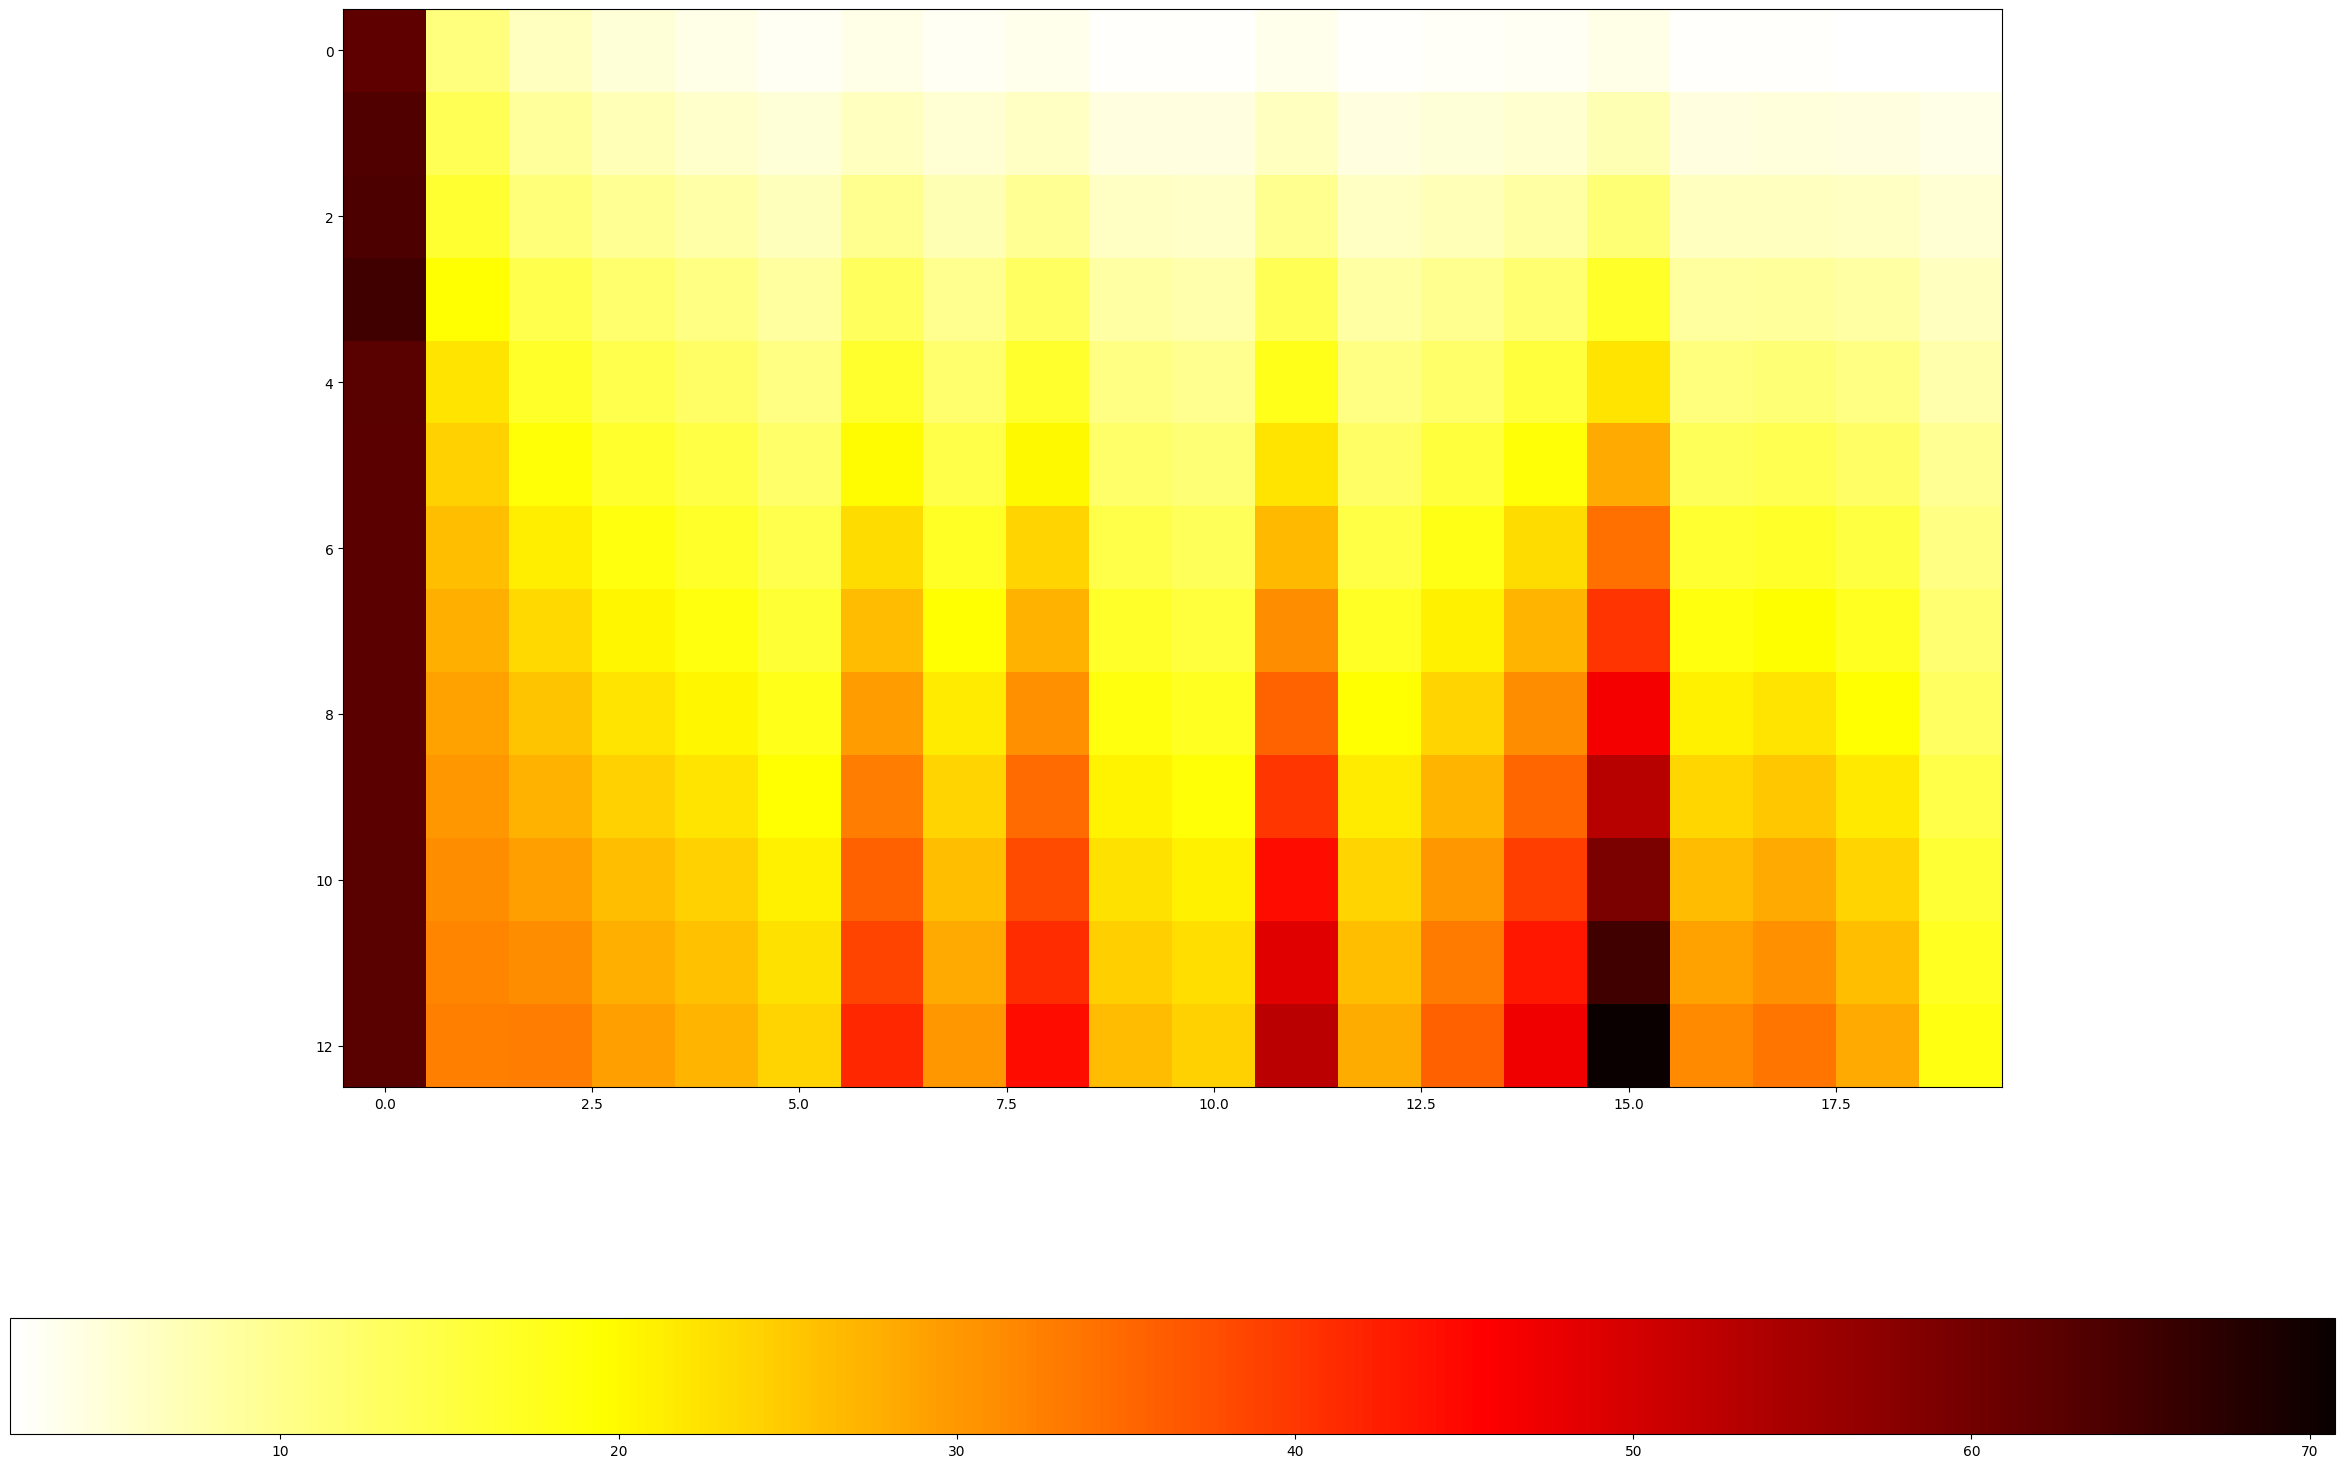

In [ ]:
plt.figure(figsize=(30, 20))
plt.imshow(np.array(autormses).T, cmap='hot_r')
# horizontal colorbar
plt.colorbar(orientation='horizontal')

In [ ]:
# save model
torch.save(model.state_dict())

In [10]:
for i in range(1, 6):
    print(i)
    model_series = df[f'M{i}'].values
    observed_series = df['SSN'].values

    model_series = torch.tensor(model_series, dtype=torch.float32)
    observed_series = torch.tensor(observed_series, dtype=torch.float32)

    data = MixedDataGenerator(model_series, observed_series)
    test_val_size = 0.6
    val_size = 0.7

    train_data_X, test_data_X, train_data_y, test_data_y = train_test_split(data.X, data.y, test_size=test_val_size, shuffle=False)
    val_data_X, test_data_X, val_data_y, test_data_y = train_test_split(test_data_X, test_data_y, test_size=val_size, shuffle=False)

    trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data_X, train_data_y), batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_data_X, val_data_y), batch_size=64, shuffle=False)

    model = NARX(input_size=MODEL_SERIES_INPUT_SIZE + OBSERVED_SERIES_INPUT_SIZE, hidden_size=24, output_size=1)
    model.to(device)
    
    train_losses, val_losses, autormses = model.train_model(trainloader, valloader, data, epochs=10000, lr=0.001)
    
    #  save model with name i
    torch.save(model.state_dict(), f'model_{i}.pt')
    # save autormses
    np.save(f'autormses_{i}', autormses)

1


Training: 100%|██████████| 10000/10000 [23:35<00:00,  7.07epoch/s] 


2


Training: 100%|██████████| 10000/10000 [23:59<00:00,  6.95epoch/s] 


3


Training: 100%|██████████| 10000/10000 [17:38<00:00,  9.45epoch/s]


4


Training: 100%|██████████| 10000/10000 [18:08<00:00,  9.19epoch/s]


5


Training: 100%|██████████| 10000/10000 [17:43<00:00,  9.41epoch/s] 


In [13]:
rmses = [np.load(f'autormses_{i}.npy') for i in range(1, 6)]
rmses = np.array(rmses)
rmses.shape

(5, 100, 13)

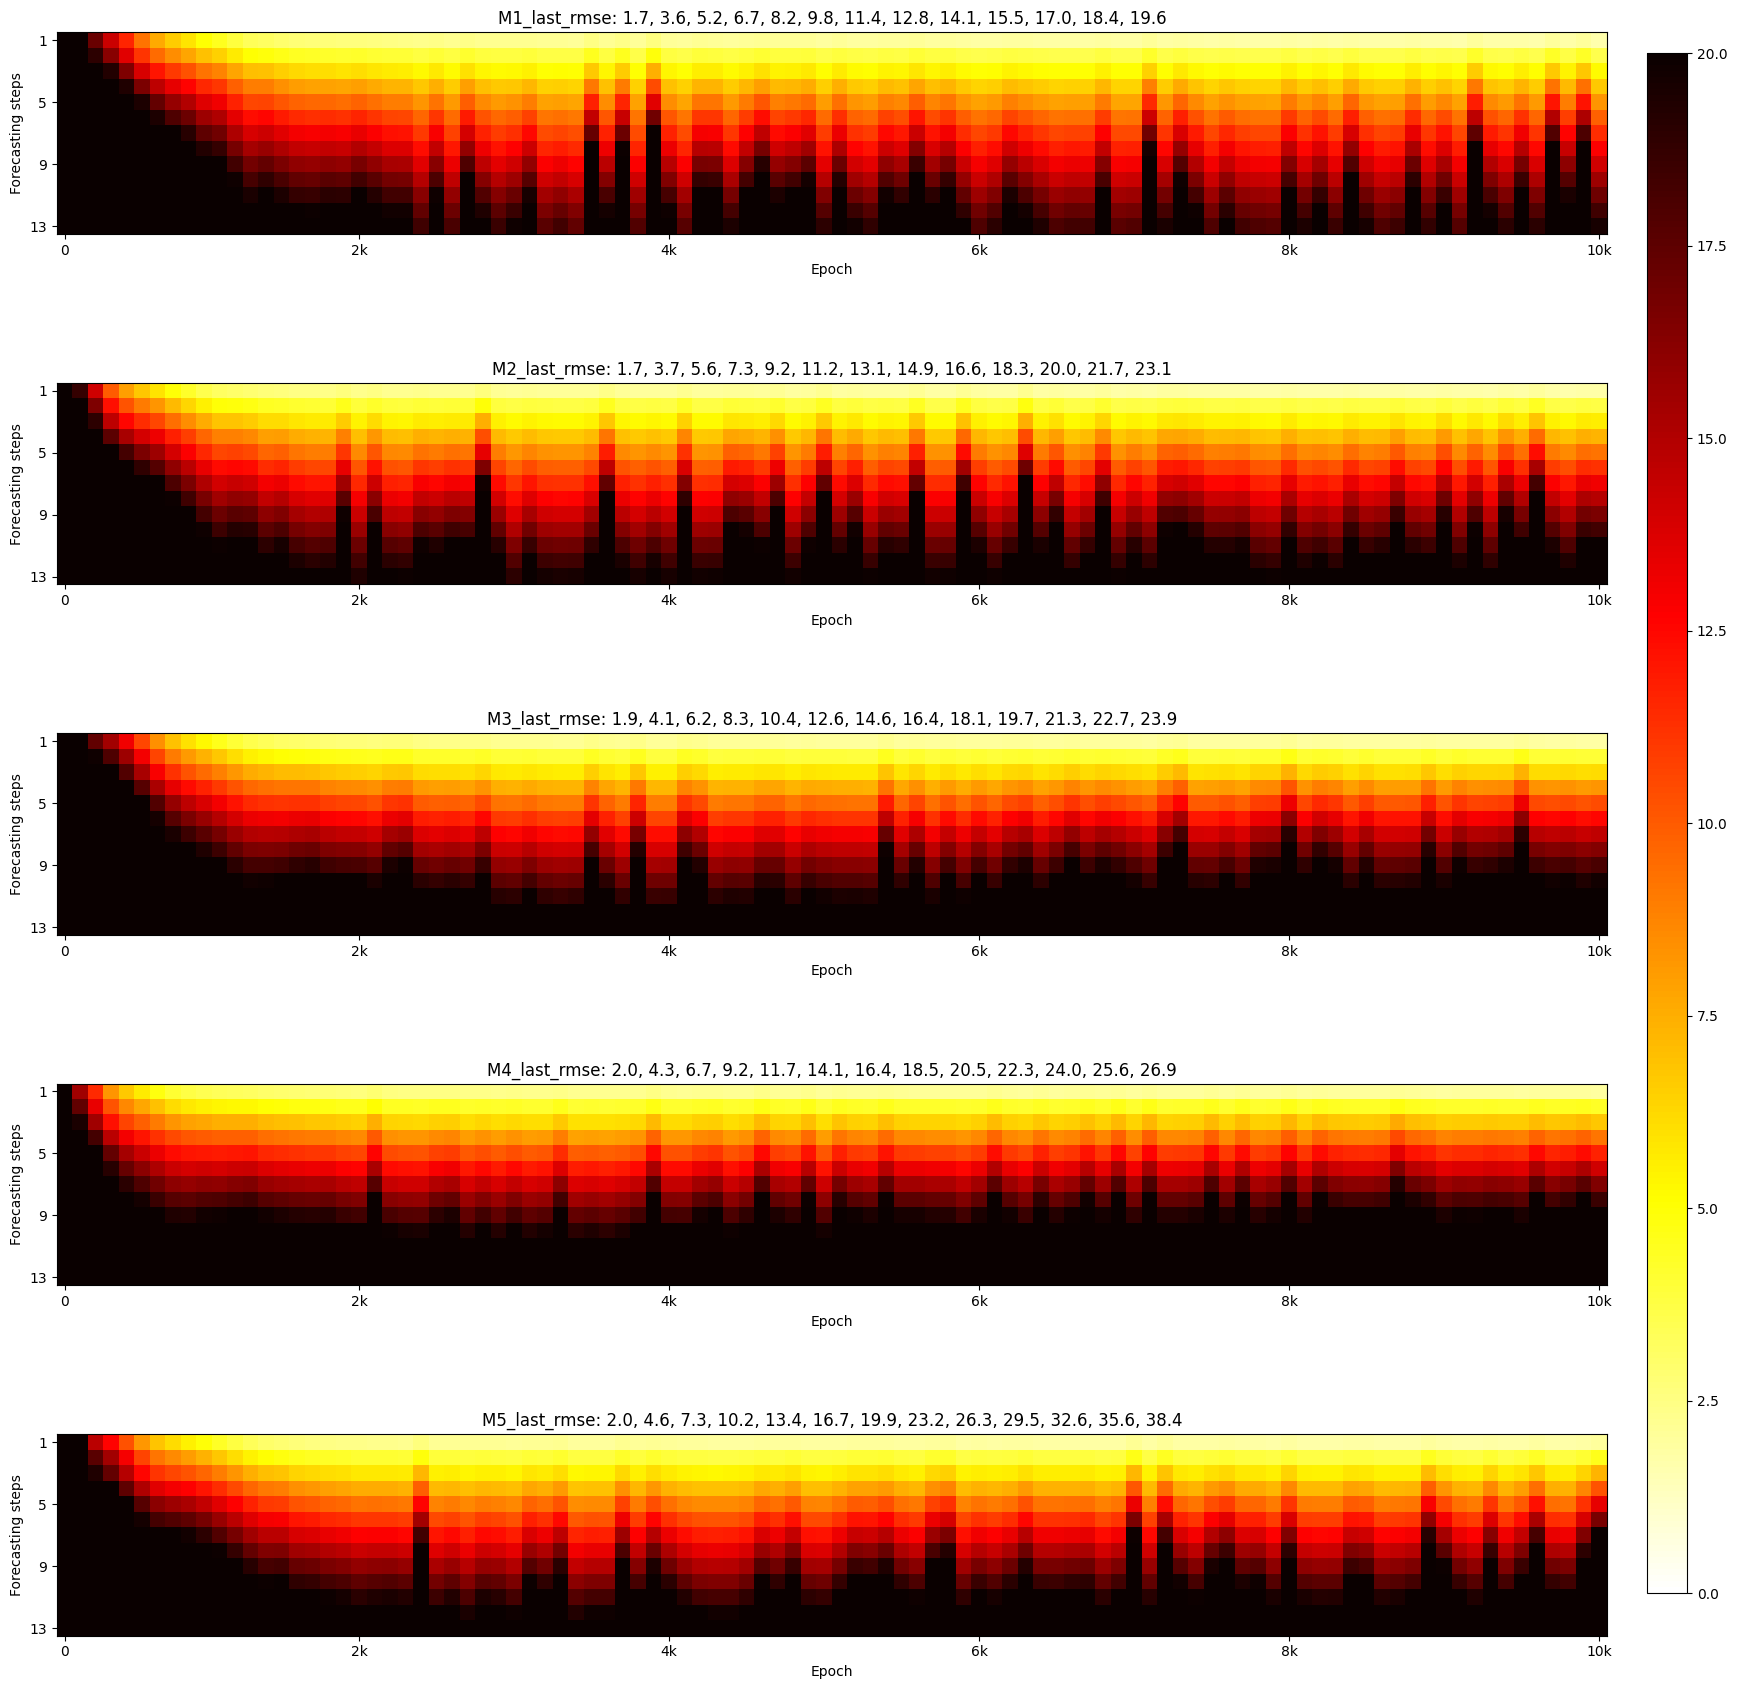

In [81]:
fig, axs = plt.subplots(5, 1, figsize=(20, 22))

for i, rmse in enumerate(rmses):
    ax = axs[i]
    im = ax.imshow(rmse.T, cmap='hot_r', vmin=0, vmax=20)
    r_s = ', '.join([f'{x:.1f}' for x in rmse[-1]])
    ax.set_title(f'M{i + 1}_last_rmse: {r_s}')
    ax.set_xlabel('Epoch')
    ax.set_xticks([0, 19, 39, 59, 79, 99])
    ax.set_xticklabels([0, '2k', '4k', '6k', '8k', '10k'])
    ax.set_ylabel('Forecasting steps')
    ax.set_yticks([0, 4, 8, 12])
    ax.set_yticklabels([1, 5, 9, 13])

# Adding the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust rect to leave space for the colorbar
plt.show()

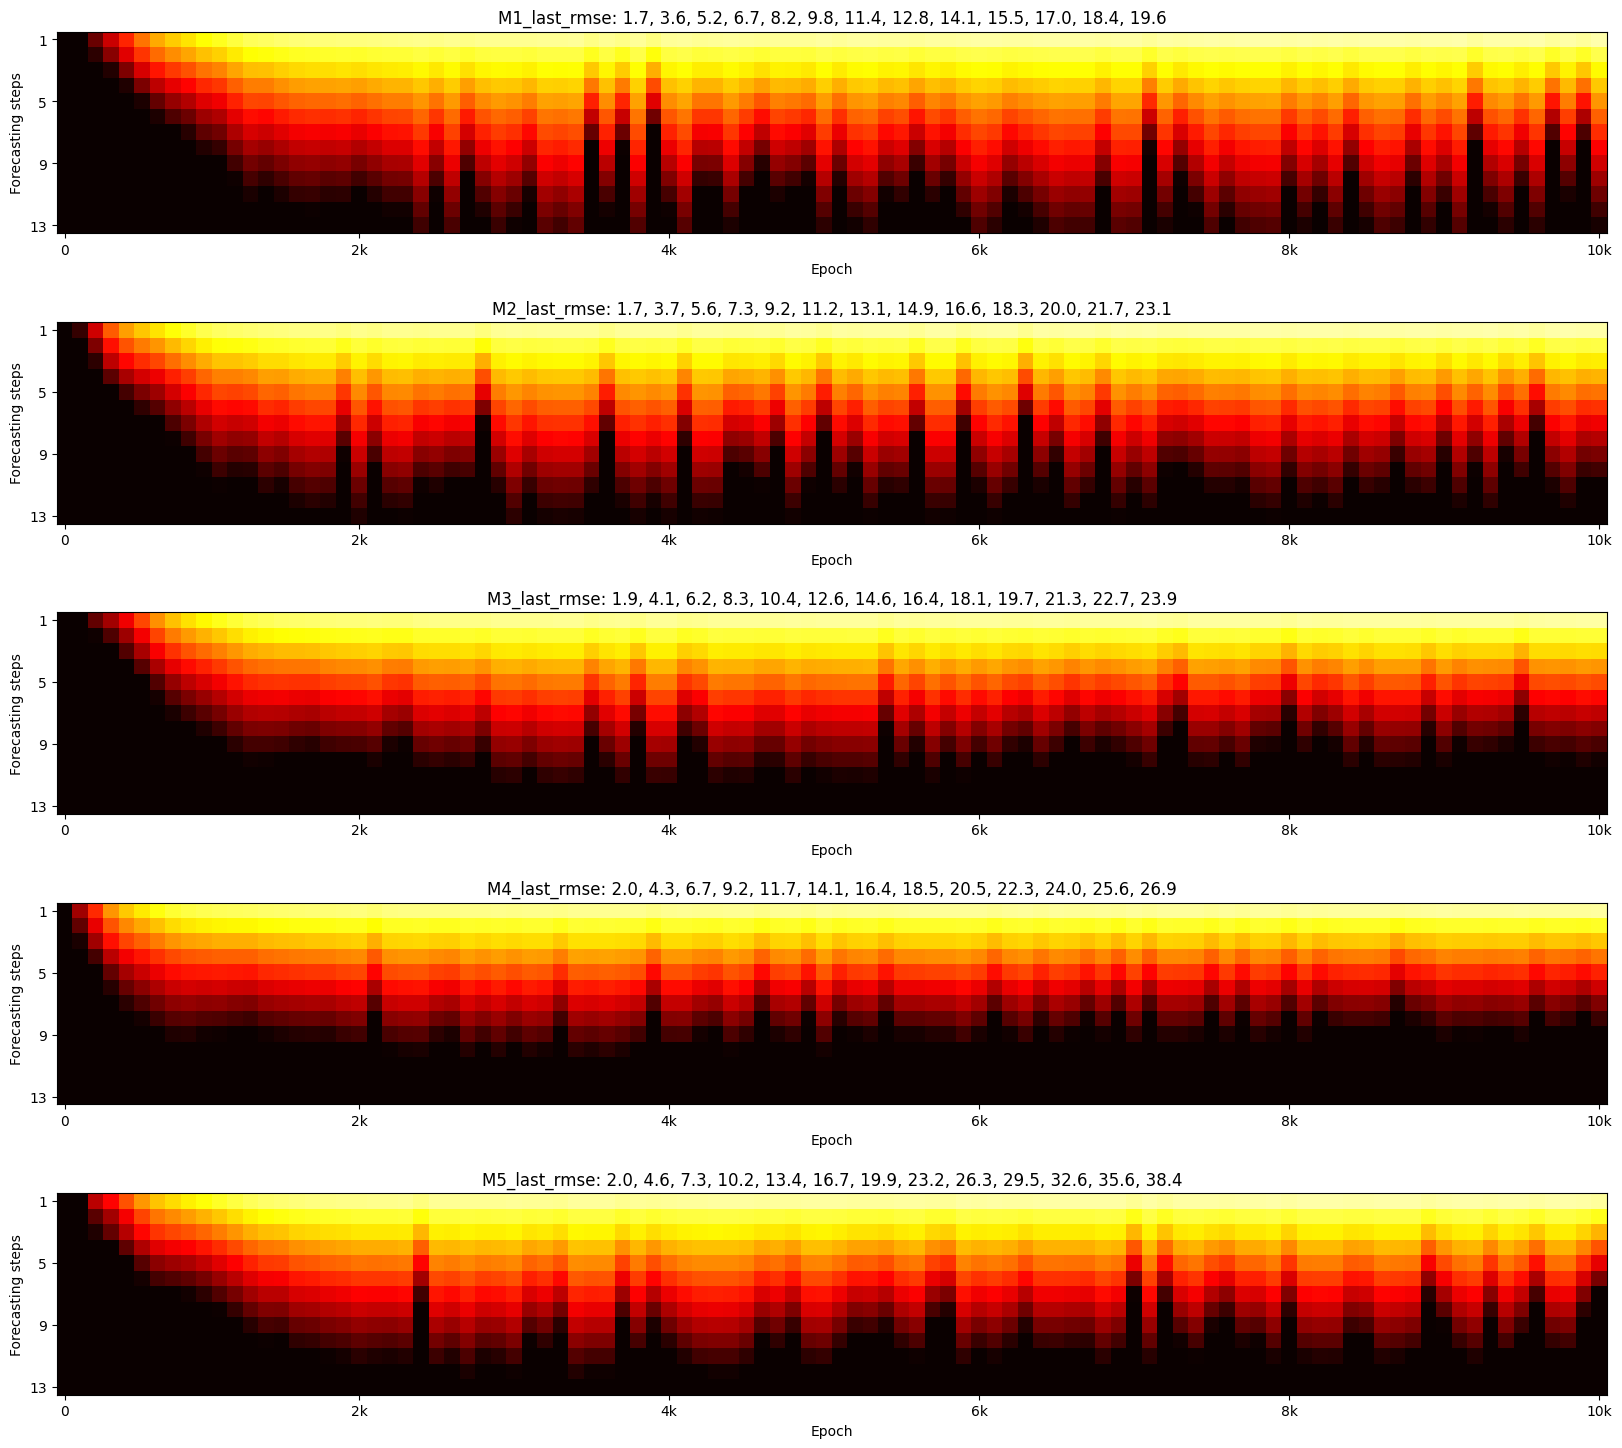

In [61]:
plt.figure(figsize=(20, 22))
for i, rmse in enumerate(rmses):
    plt.subplot(6, 1, i + 1)
    plt.imshow(rmse.T, cmap='hot_r', vmin=0, vmax=20)
    r_s = ', '.join([f'{x:.1f}' for x in rmse[-1]])
    plt.title(f'M{i + 1}_last_rmse: {r_s}')
    plt.xlabel('Epoch')
    plt.xticks(ticks=[0, 19, 39, 59, 79, 99], labels=[0, '2k', '4k', '6k', '8k', '10k'])
    plt.ylabel('Forecasting steps')
    plt.yticks(ticks=[0, 4, 8, 12], labels=[1, 5, 9, 13])